
## Movie Recommender system

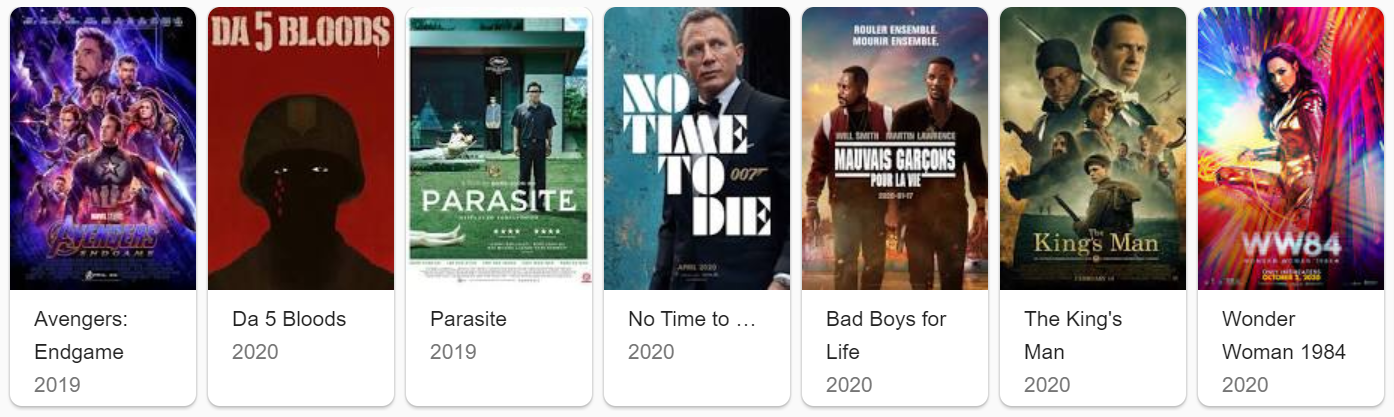

# Table of contents

### [1. Introduction](#introduction)
1.1. Project overview

1.2. Problem statement


### [2. Start Comet experiment](#scomet)
### [3. Package and module imports](#pack)
### [4. Load data](#load)
### [5. Description of the data](#dod)
### [6. Data pre-processing](#cleaning)


### [7. Exploratory Data Analysis](#eda)

### [8. Feature engineering](#pp)



### [9. Modelling](#mod)
### [10. Model evaluation](#me)
### [11. Conclusion](#conc)
### [12. End Comet experiment](#ecomet)

> <a id="introduction"></a>
# 1. Introduction

## 1.1. Project overview
Machine Learning (ML) is a subset of Artificial Intelligence (AI), dating as far back as 1959, where computers are trained to pick up patterns and make decisions with little to no human interference. There are two main types, supervised and unsupervised learning. Supervised ML algorithms are far more flexible as the datasets used do not provide label values, the computer uses trends in the data to compute results. They can be used to build recommender systems.

A recommender system is an engine or platform that can predict certain choices based on responses provided by users. A great example would be a system on a streaming platform that recommends a movie or show for a user to watch found on their previous viewings or the viewings of other users that have watching habits similar to theirs. With the increasing use of web services such as Netflix, Showmax and YouTube amongst many, there is an unfathomable amount of content available. It would be a tedious task for a user to search through it all for things that they would enjoy watching. They are also used in other services such as online shoppping stores and networking spaces like LinkedIn.

A recommender system enhances a user's experience as the luxury of recommendations will save the user the time and effort of having to search through a large catalogue. This allows for the user to also be exposed to new content, creating an opportunity for further streaming because they interact with content that is meaningful and desireable to them. In fact, most companies make a bulk of their revenue from recommendations. The rating functionality also assists in collecting data that can help the streaming platform establish trends and gather insights from what their users are consuming. This can assist in better content selection and marketing. 



## 1.2. Problem statement
Build a recommendation algorithm  that will use a user's historical preferences to accurately predict the rating that they will give a movie that they have not watched.

<a id="scomet"></a>
# 2. Start Comet Experiment

Comet is a powerful version control, cloud-based platform that is essential for project management. It allows teams to save all their models and associated (hyper)parameters used during a project. All of the models are logged as Comet experiments for sakekeeping, reproducibility and comparison.

In [1]:
# Install Comet
#!pip install comet_ml

In [2]:
# Import Experiment Class
#from comet_ml import Experiment
    
# Start experiment
#experiment = Experiment(api_key="IM4g9SQgltH0xoH1UmTZArKIV",
                        #project_name="unsupervised-predict-ts3", workspace="team-ts3-jhb")

In [3]:
# Set a new experiment name for each run
#experiment.set_name('xxxx')

<a id="pack"></a>
# 3. Package and module imports

In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import operator  
import heapq
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

from surprise import SVD, BaselineOnly, CoClustering, NMF

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/edsa-recommender-system-predict/movies.csv
/kaggle/input/edsa-recommender-system-predict/imdb_data.csv
/kaggle/input/edsa-recommender-system-predict/genome_scores.csv
/kaggle/input/edsa-recommender-system-predict/sample_submission.csv
/kaggle/input/edsa-recommender-system-predict/tags.csv
/kaggle/input/edsa-recommender-system-predict/test.csv
/kaggle/input/edsa-recommender-system-predict/links.csv
/kaggle/input/edsa-recommender-system-predict/genome_tags.csv
/kaggle/input/edsa-recommender-system-predict/train.csv


<a id="load"></a>
# 4. Load data

In [2]:
gen_scores = pd.read_csv('../input/edsa-recommender-system-predict/genome_scores.csv')
gen_tgs = pd.read_csv('../input/edsa-recommender-system-predict/genome_tags.csv')
imd = pd.read_csv('../input/edsa-recommender-system-predict/imdb_data.csv')
links = pd.read_csv('../input/edsa-recommender-system-predict/links.csv')
mvs = pd.read_csv('../input/edsa-recommender-system-predict/movies.csv')
ss = pd.read_csv('../input/edsa-recommender-system-predict/sample_submission.csv')
tgs = pd.read_csv('../input/edsa-recommender-system-predict/tags.csv')
test = pd.read_csv('../input/edsa-recommender-system-predict/test.csv')
train = pd.read_csv('../input/edsa-recommender-system-predict/train.csv')

<a id="dod"></a>
# 5. Description of the data

The dataset is derived form an online movie recommendation service called MovieLens. It consists of millions of 5-star ratings that are provided by the MovieLens' users. Additional data has been scraped from IMDB and added with the purpose to enhance the dataset. 

The supplied dataset comprises the following:

1. genome_scores.csv - A score mapping the strength between movies and tag-related properties
2. genome_tags.csv - User assigned tags for genome-related scores
3. imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file
4. links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs
5. sample_submission.csv - Sample of the submission format for the hackathon
6. tags.csv - User assigned for the movies within the dataset
7. test.csv - The test split of the dataset. Contains user and movie IDs with no rating data
8. train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data



<a id="cleaning"></a>
# 6. Data pre-processing

Data preprocessing is the process of transforming raw data into a format that makes it useful for analysis and modelling. Techniques are used to identify errors and modify or remove and parts of the data in order to improve its overall quality.

The first five rows of the all the dataframes will be displayed and also their information probed to assess the contents of the tables.

In [6]:
ss.head()

,Id,rating
0,1_2011,1.0
1,1_4144,1.0
2,1_5767,1.0
3,1_6711,1.0
4,1_7318,1.0


The expected output for the exercise is a dataframe with two columns, Id and the predicted rating. 

In [7]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [9]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [11]:
mvs.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
mvs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [13]:
tgs.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [14]:
tgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1093360 non-null  int64 
 1   movieId    1093360 non-null  int64 
 2   tag        1093344 non-null  object
 3   timestamp  1093360 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.4+ MB


In [15]:
gen_scores.head()


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [16]:
gen_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


In [17]:
gen_tgs.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [18]:
gen_tgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [19]:
imd.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [20]:
imd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        27278 non-null  int64  
 1   title_cast     17210 non-null  object 
 2   director       17404 non-null  object 
 3   runtime        15189 non-null  float64
 4   budget         7906 non-null   object 
 5   plot_keywords  16200 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


### Null values

Null values are common in datasets. They represent countless things that could have gone wrong during the collection of data or the information simply does not exist. It is imperative to check for null values and deal with them because they can cause complications whilst modelling.

In [21]:
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [22]:
links.isnull().sum()

movieId      0
imdbId       0
tmdbId     107
dtype: int64

In [23]:
tgs.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [24]:
gen_scores.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [25]:
gen_tgs.isnull().sum()

tagId    0
tag      0
dtype: int64

In [26]:
imd.isnull().sum()

movieId              0
title_cast       10068
director          9874
runtime          12089
budget           19372
plot_keywords    11078
dtype: int64

There is a noticeable number of null values in each dataframe. Each will be handled on a case basis depending on how the dataframe will be utilised. The null values can either be removed or imputed. The type of imputation will be dictated by the data type of the feature and it's perceived relevance.

### Merge datasets

The train, movies and imdb dataframes will be merged as it is easier to work with one dataframe.

In [3]:
combined_df = pd.merge(train, mvs, how = 'left',on = 'movieId')

In [4]:
combined_df = pd.merge(combined_df,imd, how = 'left', on = 'movieId')

In [29]:
combined_df.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...


### Concatenated data and special characters

The genres in the genre column are concatenated using a pipe. In order to maximise the value of this information, they must be separated

In [5]:
combined_df['genres'] = combined_df['genres'].str.split('|').str.join(',')


In [6]:
combined_df.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),"Comedy,Crime,Drama,Thriller",Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,"Action,Comedy,Sci-Fi",Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),"Adventure,Comedy,Crime",Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,"Drama,Horror,Mystery,Thriller",Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...


### Datetime formatting

The timestamp column is currently represented in a unix time format. The timestamp is changed from a unix timestamp to a readable and interpretable forma which will use in our EDA to see the variation in the ratings of the movie as the years progress.

In [32]:
combined_df['timestamp'] = combined_df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [33]:
timestamp = combined_df['timestamp'].dt.year

In [34]:
combined_df['rating_year'] = timestamp

In [35]:
combined_df.drop('timestamp', axis = 1, inplace = True)

In [36]:
combined_df.head()

,userId,movieId,rating,title,genres,title_cast,director,runtime,budget,plot_keywords,rating_year
0,5163,57669,4.0,In Bruges (2008),"Comedy,Crime,Drama,Thriller",Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,2018
1,106343,5,4.5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,2008
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,"Action,Comedy,Sci-Fi",Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...,2004
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005),"Adventure,Comedy,Crime",Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi,2015
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...,"Drama,Horror,Mystery,Thriller",Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...,1996


<a id="eda"></a>
# 7. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is great to carry out because it allows for the analysis of the data to extract any information that may be useful in modelling or pick up any trends that the models can miss. It is also useed to summarise the main characteristics of the data in order to make any insghts and recommendations.


In [37]:
train1 = train.copy()
train1.drop('timestamp', axis = 1, inplace = True)

In [43]:
ratings_per_user = train1.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)

In [47]:
ratings_per_user.head(10)

,userId,rating
72314,72315,12952
80973,80974,3680
137292,137293,3588
33843,33844,3208
20054,20055,3050
109730,109731,2671
49402,49403,2670
92045,92046,2579
110970,110971,2288
30878,30879,2284


The distribution of the number of ratings would be a great visualisation in order to see how the movies are ranked.

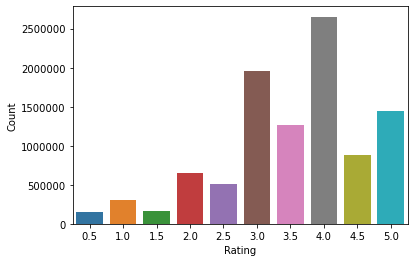

In [53]:
sns.countplot(x='rating', data=train)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The distribution of the ratings indicate that most movies have a rating of atleast 3 and a rating of 4 is the most popular. The mean rating is around 3.5. This means that most of the movies in the dataset have a fairly good score. It also means that the ratings are skewed to the right which is proven by the mean and median calcualtion below. Further, it can inferred that based on the movies which are rated below 3, 15.4% of the movies in the dataset are "bad" movies.

In [54]:
print(train['rating'].mean())
print(train['rating'].median())

3.5333951730983424
3.5


The movies can be ranked according to their average ratings.

In [55]:
ranked_movies = pd.DataFrame(combined_df.groupby('title')['rating'].mean().
                             sort_values(ascending=False))


In [56]:
ranked_movies.head()

,rating
title,
Final Recourse (2013),5.0
Lady and the Tramp (2019),5.0
Virasat (1997),5.0
Committed (2014),5.0
Sole Proprietor (2016),5.0


This table is not an accurate reflection of the best movies as some of the movies have only have a few ratings. This can influence its average rating. For example, movie A will have only one rating of 5 thus will have an average rating of 5. Contrastingly, movie B which has an average rating of 4.5 may have a 100 ratings. One could easily think that movie A is better than movie B but its not true as based on the number of ratings movie B is actually better. Therefore, it would be better to determine the best movie best on both the number of ratings it has and also its average rating as shown below.

In [57]:
ranked_movies['No_of_ratings'] = combined_df.groupby('title')['rating'].count()

In [59]:
ranked_movies.sort_values(by=['No_of_ratings', 'rating'],
                          ascending=False).head()

,rating,No_of_ratings
title,,
"Shawshank Redemption, The (1994)",4.417624,32831
Forrest Gump (1994),4.047216,32383
Pulp Fiction (1994),4.195097,31697
"Silence of the Lambs, The (1991)",4.144172,29444
"Matrix, The (1999)",4.154253,29014


As indicated by the table,the best movies are those that have both average high ratings and also a high number of ratings as they have been rated highly by large quantities of people. The average rating decreases with the decreasing number of ratings, i.e. they are positively correlated.

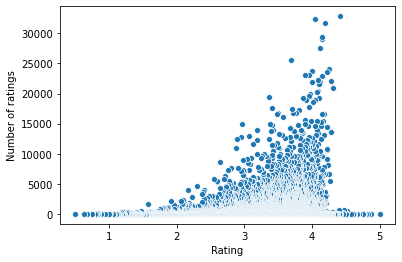

In [60]:
sns.scatterplot(x='rating', y='No_of_ratings', data=ranked_movies)
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

As expected, the higher the average ratings, the higher the number of ratings the movie has.

In [61]:
best_director = pd.DataFrame(combined_df.groupby('director')['rating'].mean().
                             sort_values(ascending=False))
best_director['No_of_movies'] = combined_df.groupby('director')['rating'].count()
best_director.sort_values(by=['No_of_movies', 'rating'], ascending=False).head()

,rating,No_of_movies
director,,
Quentin Tarantino,3.936571,109919
Michael Crichton,3.273370,65157
J.R.R. Tolkien,4.080118,62963
Lilly Wachowski,3.808348,60988
Stephen King,4.049956,59903


The directors can also be ranked in terms of the average rating that their movies have achieved and also the number of movies they have played a role in producing. It can be said that a director has built a reputation for him/herself.

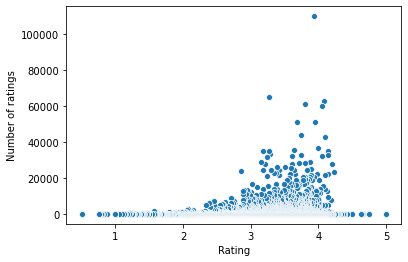

In [64]:
sns.scatterplot(x = 'rating', y = 'No_of_movies', data = best_director)
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.show()

As expected, most directors with a high number of movies have average to good movie ratings.

It would be great to determine if the ratings are affected by the year at which the ratings were made i.e. do the ratings decrease as the movie gets older? With changes in technology, audio and visuals are constantly improving. Due to this, people might give an older moviewith a low score as years progress as they would be comparing it with the current movies with better graphics.

In [65]:
yearly_rating = pd.DataFrame(combined_df.groupby(['title','rating_year'])['rating'].mean())

In [66]:
yearly_rating.reset_index(inplace = True)

In [67]:
count_ratings = pd.DataFrame(yearly_rating.groupby('title')['rating_year'].count().sort_values(ascending = False).head(10))

In [68]:
count_ratings.reset_index(inplace = True)

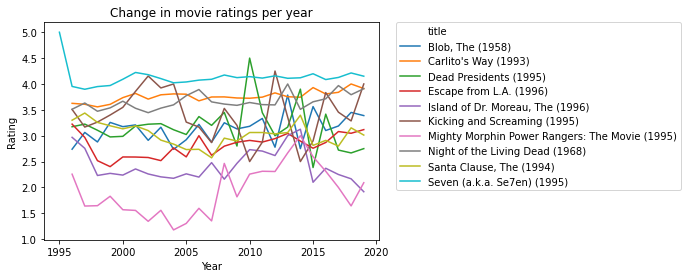

In [71]:
sns.lineplot(x="rating_year", y="rating", hue="title", 
             data=yearly_rating[yearly_rating['title'].
                                isin(count_ratings['title'])]).set_title('Change in movie ratings per year')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

From the plot above, there is a slight drop from 1995 to 2020 in annual moving ratings howver it is not significant, at all. It seems as if the ratings given to a movie each year are not hugely affected by the year that the rating was given (there is no pattern in the ratings). From this, it can be concluded that the year of the rating has no significance in predicting the ratings of the movies.

Movie duration can also be an important feature to consider when making a rating or when recommending a movie to someone as there might be viewers who do not like watching long movies or vice versa.

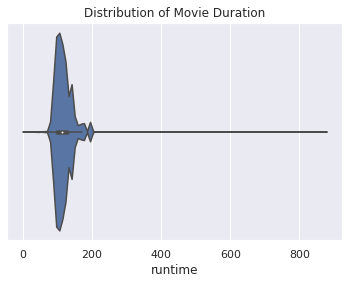

In [77]:
sns.violinplot(x = 'runtime', data = combined_df,).set_title('Distribution of Movie Duration')
plt.show()

In [ ]:
print('runtime mean: ', combined_df['runtime'].mean())
print('runtime standard deviation: ', combined_df['runtime'].std())

Most of the runtimes are centered around the mean as shown by the violin plot above and the variation between the length of the movies is quite small, as shown by the standard deviation. There are also a few outliers. Also, realistically speaking, runtime is not really important in determining if a person will watch a movie because if they really do not like watching long movies, they can simply watch it in intervals.

Each movie is asscoiated with a set of genres.

In [7]:
list_list = list(combined_df['genres'].str.split('|'))

In [8]:
genres_list = []

for i in list_list:
    for j in i:
        genres_list.append(j)
        
    
print(genres_list[0:11])
print(len(genres_list))

['Comedy,Crime,Drama,Thriller', 'Comedy', 'Action,Comedy,Sci-Fi', 'Adventure,Comedy,Crime', 'Drama,Horror,Mystery,Thriller', 'Comedy,Fantasy', 'Drama,Sci-Fi', 'Comedy,Drama', 'Animation,Children', 'Horror,Mystery', 'Comedy']
10000038


In [9]:
genres_list = pd.DataFrame(genres_list)

In [10]:
genres_list.rename(columns = {0:'genres'}, inplace = True) 

In [11]:
genres_counted = pd.DataFrame(genres_list['genres'].value_counts())

In [12]:
genres_counted.reset_index(inplace = True)
genres_counted.rename(columns = {'index':'genres','genres':'count'}, inplace = True)
genres_counted.head(50)

,genres,count
0,Drama,706335
1,Comedy,606057
2,"Comedy,Romance",360826
3,"Drama,Romance",318408
4,"Comedy,Drama",288847
5,"Comedy,Drama,Romance",286276
6,"Action,Adventure,Sci-Fi",238601
7,"Crime,Drama",238229
8,"Action,Crime,Thriller",151533
9,"Drama,Thriller",146726


The table shows the number of times that a genre appears through all the movies in the dataset. There are 10 651 movies which do not have a genre provided, as seen in row 19. Rows 14 also indicates that IMAX is considered a genre.

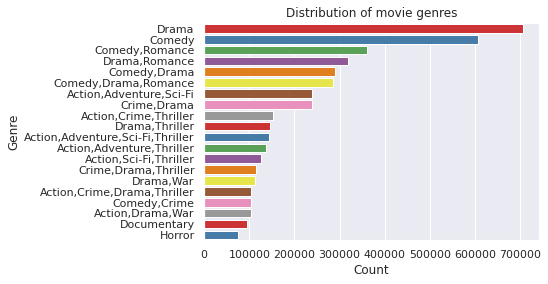

In [17]:
sns.set(style="darkgrid")
sns.barplot(x='count', y=genres_counted['genres'].head(20),
            data=genres_counted, palette='Set1').set_title('Distribution of movie genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Drama is the most common genre throughout the movies. Genres are important as they show the preferences of viewers and based on the genre that a viewer likes, movies of the same genre can be recommended.

Movies in the dataset are associated with tags. The relevance of these tags is also provided.

In [14]:
genome_df = pd.merge(gen_scores,gen_tgs, how = 'left',on = 'tagId')

In [15]:
genome_df.head()

,movieId,tagId,relevance,tag
0,1,1,0.02875,007
1,1,2,0.02375,007 (series)
2,1,3,0.06250,18th century
3,1,4,0.07575,1920s
4,1,5,0.14075,1930s


The relevance values range from 0 or near 0, to 1. A small value (closer to 0) indicates that a tag is irrelevant/less relevant to the movie and vice versa. The most important thing to do is to determine the most relevant tags and how many of them can be potentially used tin a good recommender system. 

In [19]:
genre_tag_df = genome_df.merge(mvs, on = 'movieId', how = 'outer')


In [20]:
genre_tag_df.head()

,movieId,tagId,relevance,tag,title,genres
0,1,1.0,0.02875,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2.0,0.02375,007 (series),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,3.0,0.06250,18th century,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,4.0,0.07575,1920s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,5.0,0.14075,1930s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [21]:
genre_tag_df.dropna(axis = 0, inplace = True)##dropping movies with null tags
genre_tag_df['tag_rank'] = genre_tag_df.groupby("movieId")["relevance"].rank(method = "first", 
                                                                                       ascending = False).astype('int64')

In [22]:
genre_tag_df[genre_tag_df.title == 'We Were Soldiers'][['movieId','title','tag','relevance',
                                                               'tag_rank']].sort_values(by = 'relevance'
                                                                                              , ascending = False).head(10)

,movieId,title,tag,relevance,tag_rank


The tags have been ranked per movie in descending order, with the most relevant at the top. The relevance score seems quiet accurate as they all describe what the movie entails, is based on and the message it delivered across. The next step is to determine the number of tags which can give sufficient information required to accurately predict movie rating that user will give and accurately recommend movies to the user.

In [23]:
genome_rank_agg = genre_tag_df.groupby('tag_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)
##calculating the percentage change in the median of the ranks. we will for a point where the change in the median becomes small.
genome_rank_agg['relevance_median_%_chg'] = genome_rank_agg['relevance_median'].pct_change()

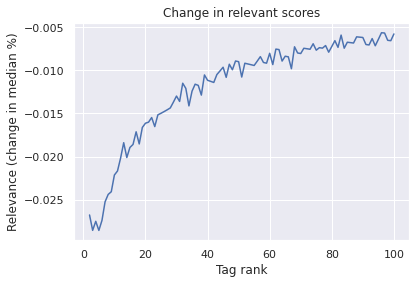

In [27]:
sns.lineplot(x="tag_rank", y="relevance_median_%_chg",
             data = genome_rank_agg).set_title('Change in relevant scores')
plt.xlabel('Tag rank')
plt.ylabel('Relevance (change in median %)')
plt.show()

The relevant scores stabalize at around rank 60, therefore the top 60 tags ranked according the their relevance score. The above figure was adopted from https://towardsdatascience.com/how-to-build-a-simple-movie-recommender-system-with-tags-b9ab5cb3b616. However, a collaborative based approach will be undertaken therefore these tags will not be used.

<a id="pp"></a>
# 8. Feature Engineering

A colaborative recommender system approach will be undertaken for this project.  The ratings of the unseen movies will be predicted using a library called Suprise. Surprise (Simple Python RecommendatIon System Engine) is a SciPy Toolkit that uses explicit rating data to create and evaluate colaborative recommender systems.

Feature engineering is the process of using data techniques to select, extract and transform features from the data in order to accurately represent the underlying structure in a form that is easily interpreted by algorithms. It is done to improve the performance of ML algorithms. Surprise requires a reader object to be defined in order for it to be able to parse through the dataframe. The rating parameter has to be specified and the data must be loaded in a raw format. The dataframe must have three columns, corresponding to the 'user ids', the 'item ids' and the ratings in this order.

In [ ]:
# Load reader and data in surprise friendly format
reader = Reader(rating_scale=(0.5, 5))
train2 = Dataset.load_from_df(train1[['userId', 'movieId', 'rating']], reader)

<a id="mod"></a>
# 9. Modelling

Surprise contains a vast catalogue of algorithms. For this exercise, the Baseline Only, Singular Value Decomposition (SVD) and CoClustering algorithms were explored. Root Mean Square Error (RMSE) was chosen as the performance metric. It measures the average magnitude of the error in the model by computing the differences between the predicted values and the actual values.

The Baseline Only algorithm is a basic algorithm that predicts the baseline estimate for the given users and items. The algorithm is very simple and does not do any 'heavy' work but it is still useful for comparing accuracies with other models.

In [ ]:
# Baseline Only model

algo_b = BaselineOnly()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_b.fit(trainset)
predictions_b = algo_b.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_b, verbose=True)

SVD is a matrix factorization-based filtering algorithm that is equivalent to Probabilistic Matrix Factorization.

In [ ]:
# SVD model

algo_svd = SVD()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_svd, verbose=True)

Co-clustering is another matrix factorization-based filtering algorithm built on the principle of co-clustering. It produces row and column clusters through simultaneously grouping objects and features in a matrix.

In [ ]:
# CoClustering model

algo_cc = CoClustering()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_cc.fit(trainset)
predictions_cc = algo_cc.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_cc, verbose=True)

NMF is a matrix factorization-based filtering algorithm based on Non-negative Matrix Factorization. It is similar to SVD.

In [ ]:
algo_nmf = NMF()

trainset, testset = train_test_split(train2, test_size = 0.1)

# train and test algorithm.
algo_nmf.fit(trainset)
predictions_nmf = algo_nmf.test(testset)

# Compute and print Root Mean Squared Error
accuracy.rmse(predictions_nmf, verbose=True)

<a id="me"></a>
# 10. Model evaluation

To evaluate the performances of the selected algorithms, they can be visualised.

In [ ]:
fig,axis = plt.subplots(figsize=(10, 6))
x1 = ['Baseline Only', 'SVD', 'Co-Clustering', 'NMF']
y1 = [0.8659, 0.8266, 0.8954 ,0.8791]
g = sns.barplot(x= x1, y= y1)
plt.title('RMSE Values',fontsize=15)
plt.ylabel('RMSE')
plt.xticks()
#for p in g.patches:
    #g.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), fontsize=12, ha='center', va='bottom')

plt.show()

Discussion of graph. These models were built on the default parameters of the algorithms and can be optimised through hyperparameter tuning. This will only be done for the SVD model as it is the best performing model.

Hyperparameter tuning is a method used to improve the performances of models by selecting a set of hyperparameters to tune. Hyperparameters are parameters whose values can be controlled during the process of training a model. From previous work studied and knowledge of how the SVD model works, the hyperparameters n_factors, n_epochs, lr_all and reg_all were chosen for tuning.

In [ ]:
algo_svd_hyp = SVD(n_factors= 150, n_epochs=75, lr_all=0.01, reg_all= 0.1)

trainset, testset = train_test_split(train1, test_size = 0.1)

algo_svd_hyp.fit(trainset)
predictions_hyp = algo_svd_hyp.test(testset)

accuracy.rmse(predictions_hyp)

The default parameters for the SVD algorithm are very close to optimal. Hyperparameter tuning has improved the RMSE from 0.8266 to 0.8202, making a 0.77% difference. This hypertuned model will be used to make predictions on the unseen data.

In [ ]:
# Predict ratings on test data using best model SVD

ratings = []

for index, row in test.iterrows():
    
    ratings.append(algo_svd_hyp.predict(row.userId, row.movieId)[3])
    
    #print(rat)
    
df = pd.DataFrame(ratings,columns=['rating'])

In [ ]:
results = pd.DataFrame({"user":test['userId'],"rating": df['rating']})

In [ ]:
ss = ss.copy()
ss['rating'] = results['rating']
ss.to_csv("predictions", index=False)

In [ ]:
# Dictionary of data to be logged

# params = {"n_factors": 150,
            #"n_epochs":"75",
            #"lr_all":"0.01",
            #"reg_all":"0.1"}
# metric = {"RMSE": xxxx}

In [ ]:
#Log parameters and results
# experiment.log_paramaters(params)
# experiemnt.log_metrics(metrics)

<a id="conc"></a>
# 11. Conclusion

<a id="ecomet"></a>
# 12. End Comet experiment

In [ ]:
#experiment.end()

In [ ]:
#experiment.display()